In [1]:
import transformers
print(transformers.__version__)

/Users/user/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.47.1


In [2]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv("data/bbc_text/bbc-text.csv")
df.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [4]:
df.shape

(2225, 2)

Histogram of the count of text

In [5]:
df['count'] = df['text'].apply(lambda x: len(x.split()))
df.head(10)

,category,text,count
0,tech,tv future in the hands of viewers with home th...,737
1,business,worldcom boss left books alone former worldc...,300
2,sport,tigers wary of farrell gamble leicester say ...,246
3,sport,yeading face newcastle in fa cup premiership s...,341
4,entertainment,ocean s twelve raids box office ocean s twelve...,260
5,politics,howard hits back at mongrel jibe michael howar...,633
6,politics,blair prepares to name poll date tony blair is...,269
7,sport,henman hopes ended in dubai third seed tim hen...,191
8,sport,wilkinson fit to face edinburgh england captai...,157
9,entertainment,last star wars not for children the sixth an...,237


<Figure size 1000x600 with 0 Axes>

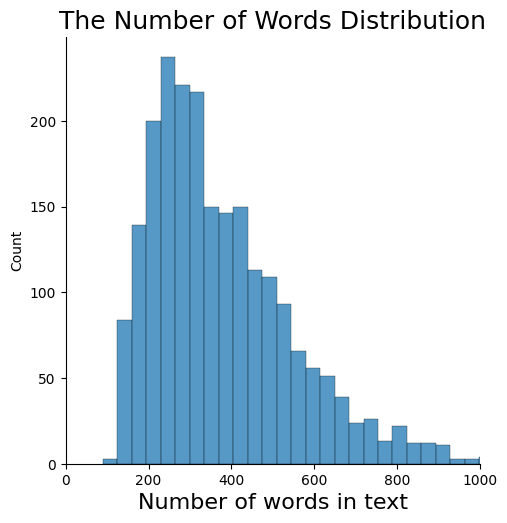

In [6]:
plt.figure(figsize=(10, 6))

sns.displot(df['count'])
plt.xlim(0, 1000)

plt.xlabel('Number of words in text', fontsize=16)
plt.title('The Number of Words Distribution', fontsize=18)

plt.show()

Bar plot for each of the new category

In [7]:
category_count = df['category'].value_counts()

categories = category_count.index

categories

Index(['sport', 'business', 'politics', 'tech', 'entertainment'], dtype='object', name='category')

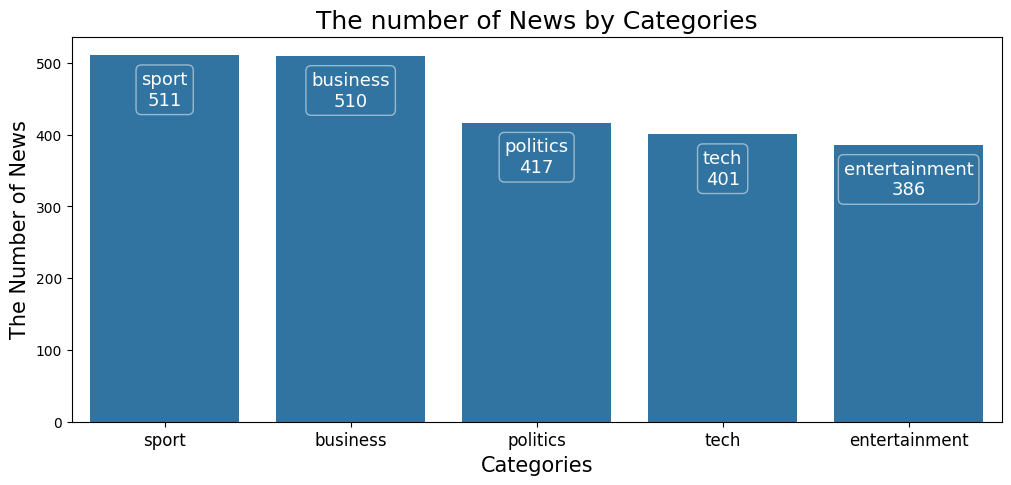

In [8]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)

plt.show()

In [9]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [10]:
df['encoded_text'] = df['category'].astype('category').cat.codes

df.head(10)

,category,text,count,encoded_text
0,tech,tv future in the hands of viewers with home th...,737,4
1,business,worldcom boss left books alone former worldc...,300,0
2,sport,tigers wary of farrell gamble leicester say ...,246,3
3,sport,yeading face newcastle in fa cup premiership s...,341,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,260,1
5,politics,howard hits back at mongrel jibe michael howar...,633,2
6,politics,blair prepares to name poll date tony blair is...,269,2
7,sport,henman hopes ended in dubai third seed tim hen...,191,3
8,sport,wilkinson fit to face edinburgh england captai...,157,3
9,entertainment,last star wars not for children the sixth an...,237,1


In [11]:
data_texts = df['text'].tolist()
data_labels = df['encoded_text'].tolist()

Train Test SPlit

In [12]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 42)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 42)

Model Definition

In [13]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

Fine-tuning with the TFTrainer class

In [15]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [16]:
pip install transformers[torch]

zsh:1: no matches found: transformers[torch]
Note: you may need to restart the kernel to use updated packages.


In [23]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments


training_args = TFTrainingArguments(
    output_dir='./results',          
    num_train_epochs=7,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=1e-5,               
    logging_dir='./logs',            
    eval_steps=100                   
)

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 5 )


trainer = TFTrainer(
    model=trainer_model,                 
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
)

trainer.train()

In [ ]:
trainer.evaluate()

Saving & Loading the model

In [ ]:
save_directory = "/saved_models" 

model.save_pretrained(save_directory)

toknizer.save_pretrained(save_directory)

In [ ]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

In [ ]:
test_text = test_texts[0]

test_text

In [ ]:
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation = True,
    padding = True,
    return_tensors = 'tf'    
)

output = model_fine_tuned(predict_input)[0]

prediction_value = tf.argmax(output, axis = 1).numpy()[0]

prediction_value

Inferencing with Pytorch

In [ ]:
import torch

from transformers import DistilBertForSequenceClassification

tokenizer_fine_tuned_pt = DistilBertTokenizer.from_pretrained(save_directory)


model_fine_tuned_pt = DistilBertForSequenceClassification.from_pretrained(save_directory, from_tf = True )

In [ ]:
predict_input_pt = tokenizer_fine_tuned_pt(test_text, truncation = True, padding = True, return_tensors = 'pt' )

ouput_pt = model_fine_tuned_pt(predict_input_pt)

prediction_value_pt = torch.argmax(ouput_pt[0], dim = 1 ).item()

prediction_value_pt